In [7]:
import numpy as np
import pandas as pd
from unidecode import unidecode
from difflib import SequenceMatcher

One of the most contentious and seemingly arbitrary aspects of the sport of mixed martial arts is judging decisions. If you're not familiar, every fight is either 3 or 5 rounds, and if a finish isnt achieved within the time limit, 3 judges will have judged each individual round. Each round is based off of a 10 point must system, awarding the chosen winner 10 and the loser less than 10.

Judging has been critisized by fans and fighters alike due to the vagueness of how much factors like damage, control time, grappling, octogon control, etc. are actually valued in an assessment of a round. The goal of this project is to analyze historical data across all UFC rounds, in addition to fan/media agreement on decisions. 

This notebook takes data from python code that web srapes two sites: mmadecisions.com (for decisions/ fan and media scoring) and UFCstats.com (for round by round statistics). These scripts utilizes microprocessing to optimize the time it takes to gether all the information. We start by converting the combined csv files to a 103x2306 dataframe.

In [3]:
UFC_df = pd.read_csv('output.csv')
UFC_df.head(15)
#method: 0= KO/TKO, 1= Submission, 2 =Unanimous decision, 3=Split decision, 4=NC/DRAW

,Number_of_Rounds,Opponent_A_Wins,Method,Opponent_A,Total_Strikes_Attempted_(A),Round_1_Sig_Strikes_Attempted_(A),Round_1_Sig_Strikes_Landed_(A),Round_1_KD_(A),Round_1_TD_(A),Round_1_Sub_Attempts_(A),...,Rd2C,Rd3C,Rd4C,Rd5C,Media score ratio of agreement,Rd1 Fans,Rd2 Fans,Rd3 Fans,Rd4 Fans,Rd5 Fans
0,5,1,2,Mackenzie Dern,340,42,23,1,0,0,...,-1,2,1,2,1.0,1.622,-0.828,2.043,0.926,1.741
1,3,1,2,Karolina Kowalkiewicz,249,84,42,0,0,0,...,1,1,--,--,1.0,NaN,NaN,NaN,NaN,NaN
2,3,0,3,Ilir Latifi,105,44,28,0,0,0,...,-1,-1,--,--,0.923,0.842,-0.684,0.316,NaN,NaN
3,3,1,2,Chase Hooper,340,101,60,0,0,0,...,1,1,--,--,1.0,1.267,0.999,1.001,NaN,NaN
4,3,0,2,Takashi Sato,76,8,3,0,1,0,...,1,1,--,--,1.0,NaN,NaN,NaN,NaN,NaN
5,3,0,2,Anthony Smith,95,22,10,0,1,0,...,-1,1,--,--,1.0,0.955,0.254,1.150,NaN,NaN
6,3,1,2,Karl Williams,191,43,19,0,1,0,...,-1,1,--,--,1.0,0.914,-0.392,-0.044,NaN,NaN
7,3,0,2,Cody Stamann,152,39,14,0,1,0,...,1,-1,--,--,0.714,0.531,0.698,-1.094,NaN,NaN
8,3,0,3,Ji Yeon Kim,62,5,1,0,0,0,...,-1,-1,--,--,0.091,-0.696,0.033,0.043,NaN,NaN
9,5,1,3,Aljamain Sterling,261,34,20,0,2,0,...,1,-1,1,-1,0.913,0.904,-0.330,-0.167,0.826,-0.890


First, the data needs to be cleansed, to store the data in rows of 8 as individual round statistics for the round winner instead of total fight statistics.

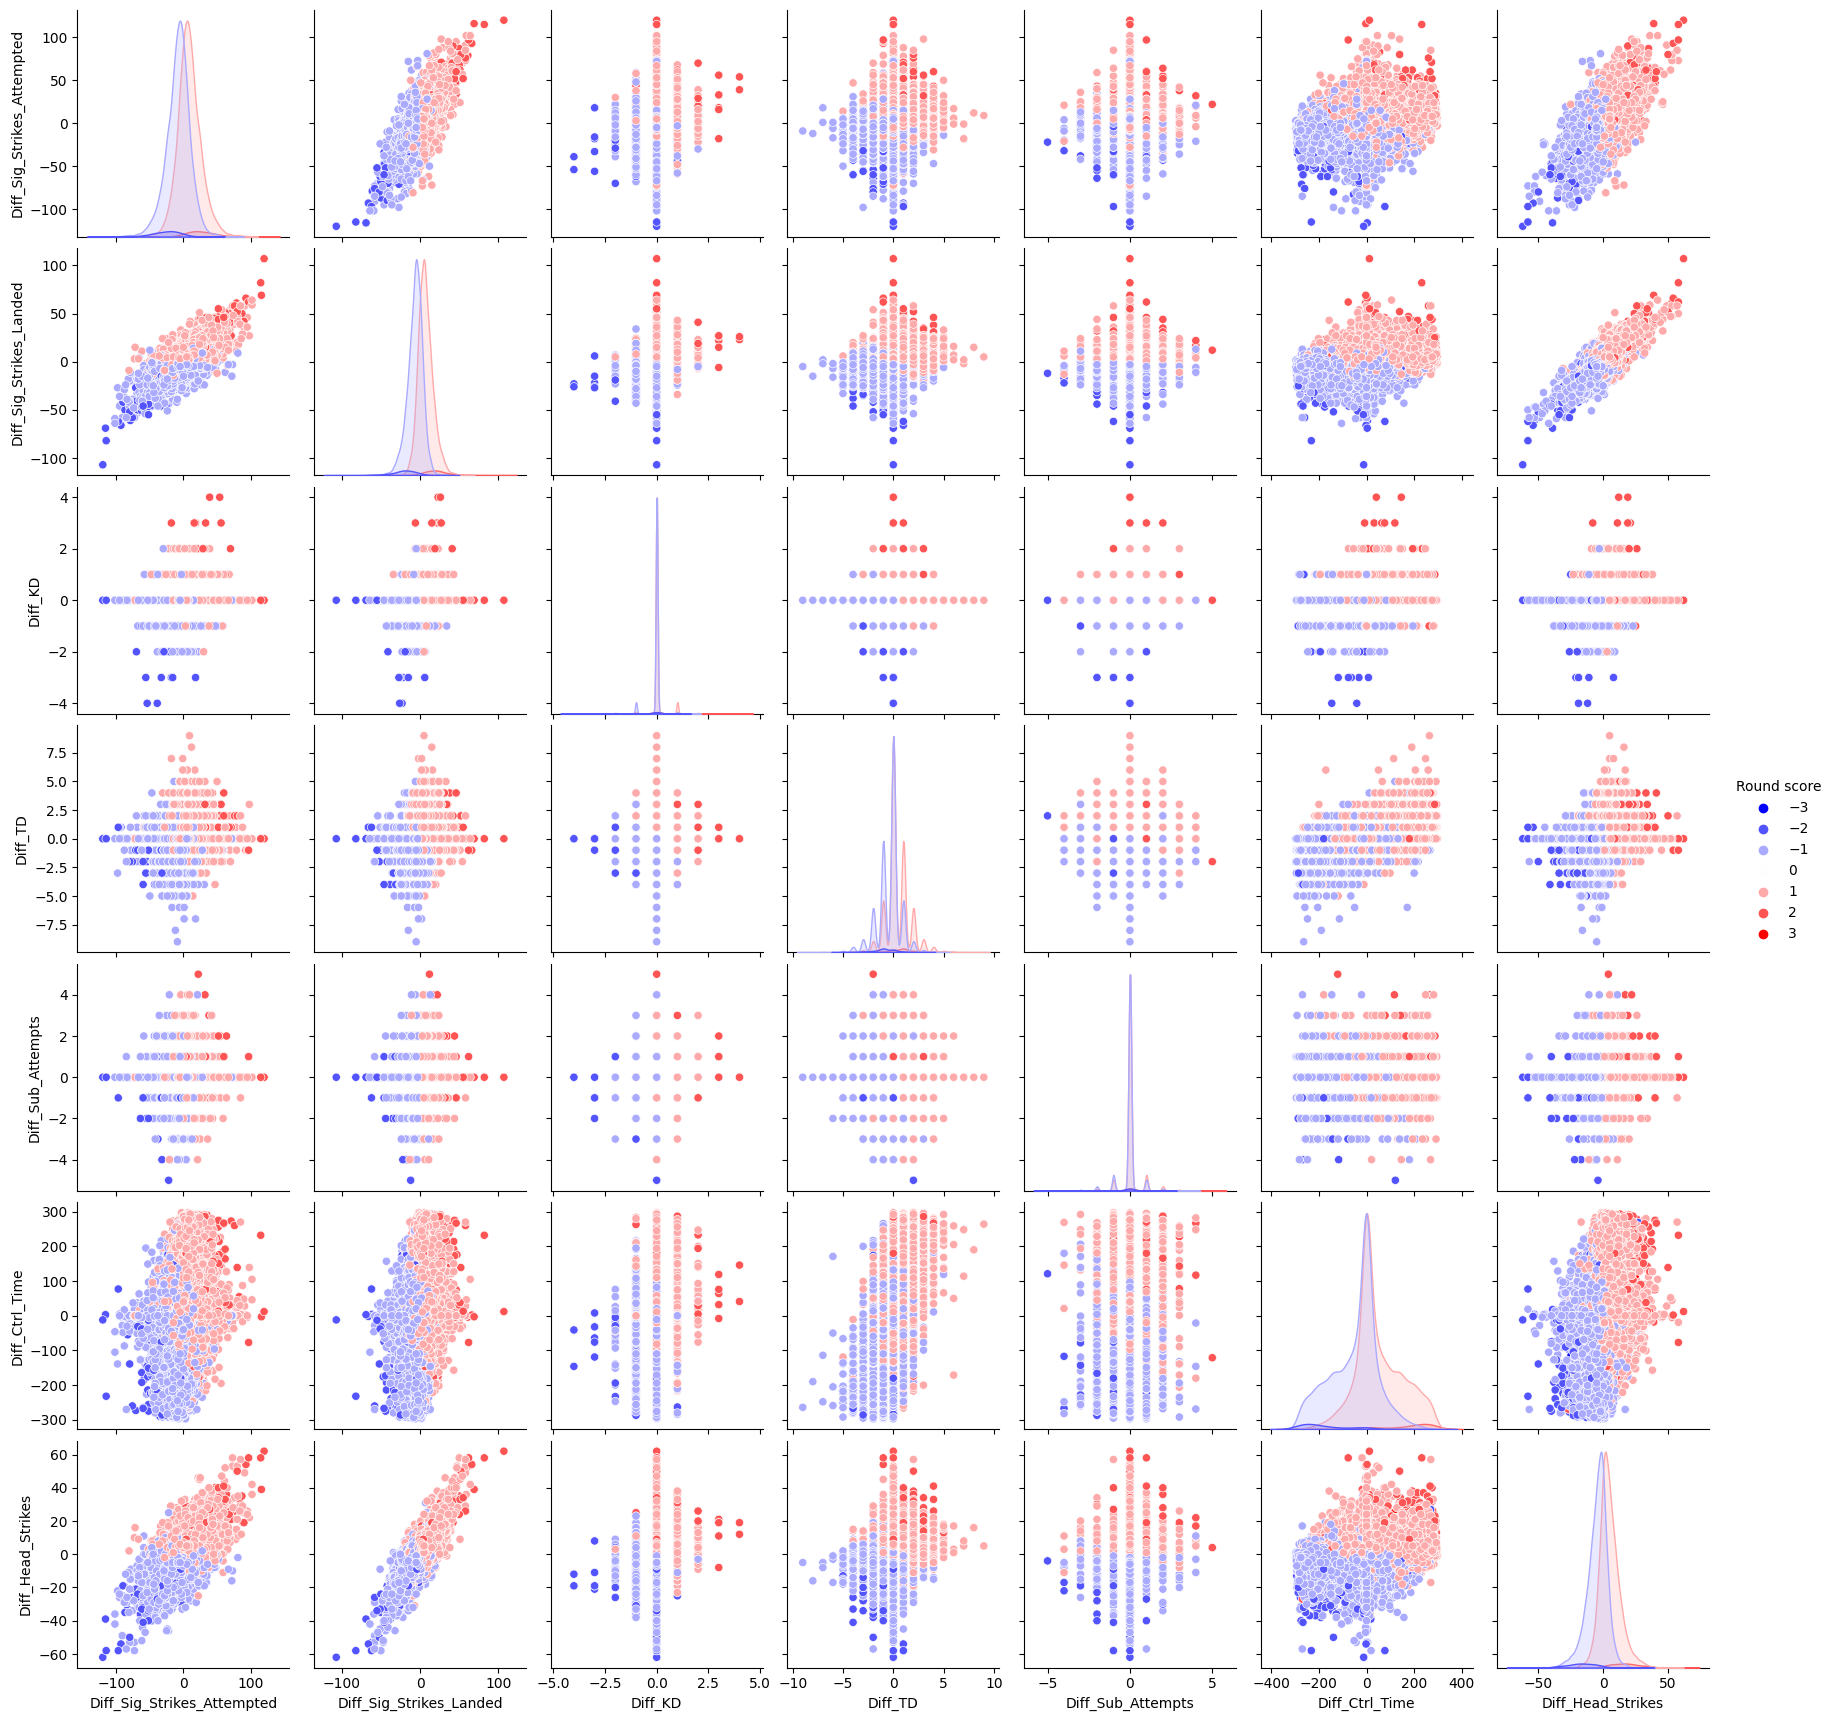

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
        
def get_sec(time_str):
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)
new_columns =[ 'Round score', 'Diff_Sig_Strikes_Attempted','Diff_Sig_Strikes_Landed','Diff_KD','Diff_TD','Diff_Sub_Attempts','Diff_Ctrl_Time','Diff_Head_Strikes']
fans_columns =['fan score']
rounds_df = pd.DataFrame(columns=new_columns)
fans_df = pd.DataFrame(columns=fans_columns)
for rowtuple in UFC_df.itertuples():
    row= list(rowtuple)[1:]
    list1 =[int(row [82]),int(row [87]), int(row [92])]
    round1avg = max(set(list1), key=list1.count)
    
    list2 =[int(row [83]),int(row [88]), int(row [93])]
    round2avg = max(set(list2), key=list2.count)

    list3 =[int(row [84]),int(row [89]), int(row [94])]
    round3avg = max(set(list3), key=list3.count)

    if((row[85] != 'nan') & (row[85] != '--')):
        list4 =[int(row [85]),int(row [90]), int(row [95])]
        round4avg = max(set(list4), key=list4.count)
        list5 =[int(row [86]),int(row [91]), int(row [96])]
        round5avg = max(set(list5), key=list5.count)

    else:
        round4avg ='skip'
        round5avg ='skip'

    round1infoA = row[5:12]
    round2infoA = row[12:19]
    round3infoA = row[19:26]
    round4infoA = row[26:33]
    round5infoA = row[33:40]

    round1infoB = row[42:49]
    round2infoB = row[49:56]
    round3infoB = row[56:63]
    round4infoB = row[63:70]
    round5infoB = row[70:77]

    if(row[80]=='DRAW'):
        if(  SequenceMatcher(a=unidecode(row[81]).lower(), b=unidecode(row[3]).lower()).ratio() >=0.8):
            templist =[round1infoA,round2infoA,round3infoA,round4infoA,round5infoA,
                    round1infoB,round2infoB,round3infoB,round4infoB,round5infoB]
        else:
            templist =[round1infoB,round2infoB,round3infoB,round4infoB,round5infoB,
                    round1infoA,round2infoA,round3infoA,round4infoA,round5infoA,]
    else:
        if (int(row[1])== 1):
            templist =[round1infoA,round2infoA,round3infoA,round4infoA,round5infoA,
                    round1infoB,round2infoB,round3infoB,round4infoB,round5infoB]
        else:
            templist =[round1infoB,round2infoB,round3infoB,round4infoB,round5infoB,
                    round1infoA,round2infoA,round3infoA,round4infoA,round5infoA,]
    
    for info in templist:
        if(info[5] != '--'):
            info[5] = get_sec(info[5])

    if(round1avg >= 0):
        rinfo =templist[0]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[5])]
        rinfo.insert(0, int(round1avg))
        rinv = [ -x for x in rinfo ]
        rounds_df.loc[len(rounds_df.index)] = rinfo
        rounds_df.loc[len(rounds_df.index)] = rinv
        fans_df.loc[len(fans_df.index)] = row[99]
        fans_df.loc[len(fans_df.index)] = -row[99]                           
    else:
        rinfo =templist[5]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[0])]
        rinfo.insert(0, -int(round1avg))
        rinv = [ -x for x in rinfo ]
        rounds_df.loc[len(rounds_df.index)] = rinfo
        rounds_df.loc[len(rounds_df.index)] = rinv
        fans_df.loc[len(fans_df.index)] = -row[99]
        fans_df.loc[len(fans_df.index)] = row[99]                       

    if(round2avg >= 0):
        rinfo =templist[1]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[6])]
        rinfo.insert(0, int(round2avg))
        rinv = [ -x for x in rinfo ]
        rounds_df.loc[len(rounds_df.index)] = rinfo
        rounds_df.loc[len(rounds_df.index)] = rinv
        fans_df.loc[len(fans_df.index)] = row[100]         
        fans_df.loc[len(fans_df.index)] = -row[100]

    else:
        rinfo =templist[6]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[1])]
        rinfo.insert(0,  -int(round2avg))
        rinv = [ -x for x in rinfo ]
        rounds_df.loc[len(rounds_df.index)] = rinfo
        rounds_df.loc[len(rounds_df.index)] = rinv
        fans_df.loc[len(fans_df.index)] = -row[100]         
        fans_df.loc[len(fans_df.index)] = row[100]
                                      
    if(round3avg >= 0):
        rinfo =templist[2]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[7])]
        rinfo.insert(0, int(round3avg))
        rinv = [ -x for x in rinfo ]
        rounds_df.loc[len(rounds_df.index)] = rinfo
        rounds_df.loc[len(rounds_df.index)] = rinv
        fans_df.loc[len(fans_df.index)] = row[101]         
        fans_df.loc[len(fans_df.index)] = -row[101]                       
    else:
        rinfo =templist[7]
        rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[2])]
        rinfo.insert(0,  -int(round3avg))
        rinv = [ -x for x in rinfo ]
        rounds_df.loc[len(rounds_df.index)] = rinfo
        rounds_df.loc[len(rounds_df.index)] = rinv
        fans_df.loc[len(fans_df.index)] = -row[101]         
        fans_df.loc[len(fans_df.index)] = row[101]                       

    if(round4avg != 'skip'):
        if(round4avg >= 0):
            rinfo =templist[3]
            rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[8])]
            rinfo.insert(0, int(round4avg))
            rinv = [ -x for x in rinfo ]
            rounds_df.loc[len(rounds_df.index)] = rinfo
            rounds_df.loc[len(rounds_df.index)] = rinv
            fans_df.loc[len(fans_df.index)] = row[102]         
            fans_df.loc[len(fans_df.index)] = -row[102]           
        else:
            rinfo =templist[8]
            rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[3])]
            rinfo.insert(0,  -int(round4avg))
            rinv = [ -x for x in rinfo ]
            rounds_df.loc[len(rounds_df.index)] = rinfo
            rounds_df.loc[len(rounds_df.index)] = rinv
            fans_df.loc[len(fans_df.index)] = -row[102]         
            fans_df.loc[len(fans_df.index)] = row[102]           

    if(round5avg != 'skip'):
        if(round5avg >= 0):
            rinfo =templist[4]
            rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[9])]
            rinfo.insert(0, int(round5avg))
            rinv = [ -x for x in rinfo ]
            rounds_df.loc[len(rounds_df.index)] = rinfo
            rounds_df.loc[len(rounds_df.index)] = rinv
            fans_df.loc[len(fans_df.index)] = row[103]         
            fans_df.loc[len(fans_df.index)] = -row[103]
        else:           
            rinfo =templist[9]
            rinfo = [int(element1) - int(element2) for (element1, element2) in zip(rinfo, templist[4])]
            rinfo.insert(0,  -int(round5avg))
            rinv = [ -x for x in rinfo ]
            rounds_df.loc[len(rounds_df.index)] = rinfo
            rounds_df.loc[len(rounds_df.index)] = rinv
            fans_df.loc[len(fans_df.index)] = -row[103]         
            fans_df.loc[len(fans_df.index)] = row[103]

sns.pairplot(rounds_df[[ 'Diff_Sig_Strikes_Attempted','Diff_Sig_Strikes_Landed','Diff_KD','Diff_TD','Diff_Sub_Attempts','Diff_Ctrl_Time','Diff_Head_Strikes','Round score']], hue='Round score', palette='bwr')

In [5]:
rounds_df.to_csv( 'rounds.csv', index=False)
scores_df=rounds_df.loc[:,'Round score']
scores_df.to_csv('scores.csv', index=False)

Due to the inclusion of both winners and losers of a round, the data is symmetrical. The clearest linear relationships exist with the most commonly-associated factors like Sig strikes attempted- Head strikes,  Sig strikes landed- Head strikes, and takedowns-Control time. Almost all of 7 data features have gaussian distribution except for the piecewise distribution of takedowns and control time which is skewed left for winners. There is a problem with class imbalance since there are 14028 -1/1's, 508 2/-2's, and 4 0's and 2 3/-3's. This means 96.47% of all rounds are 10-9's. Because almost all of the very rare 10-7 rounds in the modern era are due to point deductions, we'll treat them in our network as a 10-8.  We will first experiment with a Nueral network via pytorch, approaching this as a multinomial classification problem.

In [6]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler

Creating 2 datasets

In [8]:
#Fan-affected dataset
dataset =rounds_df.to_numpy()
fansSet =fans_df.to_numpy()

scoredRounds = []
scoredFans =  []
for idx in range(len(fansSet)):
    if(not(np.isnan(fansSet[idx]))):
        scoredRounds.append(dataset[idx])
        scoredFans.append(fansSet[idx])
scoredRounds = np.array(scoredRounds)

XFans = scoredRounds[:,1:16]
yFans = scoredRounds[:,0:1]
y_4 =[]
for item in yFans:
    match item:
        case 0:
            y_4.append([1,0,0,0,0])
        case 1:
            y_4.append([0,1,0,0,0])
        case 2:
            y_4.append([0,0,1,0,0])
        case 3:
            y_4.append([0,0,1,0,0])
        case -1:
            y_4.append([0,0,0,1,0])
        case -2:
            y_4.append([0,0,0,0,1])
        case -3:
            y_4.append([0,0,0,0,1])
XFans = torch.tensor(XFans, dtype=torch.float32)
yFans = torch.tensor(y_4, dtype=torch.float32).reshape(-1, 5)

#Judge-only dataset
X = dataset[:,1:16]
y = dataset[:,0:1]
y_3 = []
for item in y:
    match item:
        case 0:
            y_3.append([1,0,0,0,0])
        case 1:
            y_3.append([0,1,0,0,0])
        case 2:
            y_3.append([0,0,1,0,0])
        case 3:
            y_3.append([0,0,1,0,0])
        case -1:
            y_3.append([0,0,0,1,0])
        case -2:
            y_3.append([0,0,0,0,1])
        case -3:
            y_3.append([0,0,0,0,1])

X = torch.tensor(X, dtype=torch.float32)
y_3 = torch.tensor(y_3, dtype=torch.float32).reshape(-1, 5)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_3, train_size=0.90, shuffle=True)

Model

In [9]:

model1 = nn.Sequential(
    nn.Linear(7, 15),
    nn.ReLU(),
    nn.Linear(15, 15),
    nn.ReLU(),
    nn.Linear(15, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    )

class_weights=[]
class_weights.append( 1-(( scores_df==0).sum()/len(rounds_df)) )
class_weights.append(1- ((( scores_df==1).sum())/len(rounds_df)) )
class_weights.append(1- ((( scores_df==2).sum() +( scores_df==3).sum())/len(rounds_df)) )
class_weights.append(1- ((( scores_df==-1).sum())/len(rounds_df)) )
class_weights.append(1- ((( scores_df==-2).sum()+( scores_df==-3).sum())/len(rounds_df)) )
class_weights=np.square(class_weights)
print('class weights:',class_weights)
loss_func = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
def loss_fn1(y_pred, y_batch, X_batch):
    return(loss_func(y_pred, y_batch))
   
#optimizer = optim.Adam(model.parameters(), lr=0.0001,)
optimizer1 = optim.SGD(model1.parameters(), lr=0.0001, momentum =0.7)
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.997)
scheduler1 = lr_scheduler.CyclicLR(optimizer1, base_lr=0.00001, max_lr=0.001, cycle_momentum=False)


class weights: [0.99944995 0.26798528 0.96523666 0.26798528 0.96523666]


Training

In [10]:
import copy
import tqdm

def train(X_train, y_train, X_test, y_test, n_epochs, batch_size, model, loss_fn, optimizer, scheduler):     
    batches_per_epoch = len(X_train) // batch_size

    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    train_loss_hist = []
    train_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []

    for epoch in range(n_epochs):
        epoch_loss = []
        epoch_acc = []
        # set model in training mode and run through each batch
        model.train()
        with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
            bar.set_description(f"Epoch {epoch}")
            for i in bar:
                # take a batch
                start = i * batch_size
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch[:, :7])
                loss = loss_fn(y_pred, y_batch, X_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # compute and store metrics
                acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
                epoch_loss.append(float(loss))
                epoch_acc.append(float(acc))
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
            scheduler.step()
        # set model in evaluation mode and run through the test set
        model.eval()
        y_pred = model(X_test[:, :7])
        ce = loss_fn(y_pred, y_test, X_test)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
        ce = float(ce)
        acc = float(acc)
        train_loss_hist.append(np.mean(epoch_loss))
        train_acc_hist.append(np.mean(epoch_acc))
        test_loss_hist.append(ce)
        test_acc_hist.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")
        
    model.load_state_dict(best_weights)
    plt.plot(train_loss_hist, label="train")
    plt.plot(test_loss_hist, label="test")
    plt.xlabel("epochs")
    plt.ylabel("cross entropy")
    plt.legend()
    plt.show()

    plt.plot(train_acc_hist, label="train")
    plt.plot(test_acc_hist, label="test")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()


Epoch 0: 100%|██████████| 3271/3271 [00:13<00:00, 240.83batch/s, acc=0, loss=0.426]   


Epoch 0 validation: Cross-entropy=0.4588738944520462, Accuracy=0.047422681003808975


Epoch 1: 100%|██████████| 3271/3271 [00:13<00:00, 247.14batch/s, acc=0, loss=0.424]   


Epoch 1 validation: Cross-entropy=0.45479438757970964, Accuracy=0.054295532405376434


Epoch 2: 100%|██████████| 3271/3271 [00:13<00:00, 244.46batch/s, acc=0, loss=0.422]   


Epoch 2 validation: Cross-entropy=0.4508399820306109, Accuracy=0.06872852146625519


Epoch 3: 100%|██████████| 3271/3271 [00:12<00:00, 266.01batch/s, acc=0, loss=0.421]   


Epoch 3 validation: Cross-entropy=0.446786751479819, Accuracy=0.08591065555810928


Epoch 4: 100%|██████████| 3271/3271 [00:11<00:00, 272.98batch/s, acc=0, loss=0.419]   


Epoch 4 validation: Cross-entropy=0.44252924314738834, Accuracy=0.10103093087673187


Epoch 5: 100%|██████████| 3271/3271 [00:12<00:00, 262.88batch/s, acc=0, loss=0.417]   


Epoch 5 validation: Cross-entropy=0.43796005233955715, Accuracy=0.12783505022525787


Epoch 6: 100%|██████████| 3271/3271 [00:12<00:00, 266.26batch/s, acc=0, loss=0.415]   


Epoch 6 validation: Cross-entropy=0.4330365762541903, Accuracy=0.24398624897003174


Epoch 7: 100%|██████████| 3271/3271 [00:12<00:00, 267.78batch/s, acc=0.25, loss=0.413]


Epoch 7 validation: Cross-entropy=0.42767998396592877, Accuracy=0.5676975846290588


Epoch 8: 100%|██████████| 3271/3271 [00:11<00:00, 277.86batch/s, acc=0.25, loss=0.411]


Epoch 8 validation: Cross-entropy=0.4218783999332368, Accuracy=0.5821306109428406


Epoch 9: 100%|██████████| 3271/3271 [00:11<00:00, 276.62batch/s, acc=0.25, loss=0.41] 


Epoch 9 validation: Cross-entropy=0.41558871305296663, Accuracy=0.6006872653961182


Epoch 10: 100%|██████████| 3271/3271 [00:13<00:00, 238.16batch/s, acc=0.25, loss=0.408]


Epoch 10 validation: Cross-entropy=0.4088859707000423, Accuracy=0.6254295706748962


Epoch 11: 100%|██████████| 3271/3271 [00:13<00:00, 243.98batch/s, acc=0.25, loss=0.407]


Epoch 11 validation: Cross-entropy=0.4019929104711586, Accuracy=0.6357388496398926


Epoch 12: 100%|██████████| 3271/3271 [00:12<00:00, 258.57batch/s, acc=0.25, loss=0.406]


Epoch 12 validation: Cross-entropy=0.3952696256868737, Accuracy=0.6453608274459839


Epoch 13: 100%|██████████| 3271/3271 [00:12<00:00, 257.46batch/s, acc=0.25, loss=0.405]


Epoch 13 validation: Cross-entropy=0.38909619262162637, Accuracy=0.6570446491241455


Epoch 14: 100%|██████████| 3271/3271 [00:12<00:00, 264.66batch/s, acc=0.25, loss=0.405]


Epoch 14 validation: Cross-entropy=0.38368507009650576, Accuracy=0.6632302403450012


Epoch 15: 100%|██████████| 3271/3271 [00:13<00:00, 241.01batch/s, acc=0.25, loss=0.404]


Epoch 15 validation: Cross-entropy=0.378956365074074, Accuracy=0.6632302403450012


Epoch 16: 100%|██████████| 3271/3271 [00:12<00:00, 262.78batch/s, acc=0.25, loss=0.402]


Epoch 16 validation: Cross-entropy=0.37469005242930464, Accuracy=0.6666666865348816


Epoch 17: 100%|██████████| 3271/3271 [00:12<00:00, 265.32batch/s, acc=0.25, loss=0.401]


Epoch 17 validation: Cross-entropy=0.37065127916295015, Accuracy=0.6687285304069519


Epoch 18: 100%|██████████| 3271/3271 [00:12<00:00, 255.03batch/s, acc=0.25, loss=0.398]


Epoch 18 validation: Cross-entropy=0.3666876786589701, Accuracy=0.6790378093719482


Epoch 19: 100%|██████████| 3271/3271 [00:12<00:00, 258.19batch/s, acc=0.25, loss=0.394]


Epoch 19 validation: Cross-entropy=0.3627143562893884, Accuracy=0.6817869544029236


Epoch 20: 100%|██████████| 3271/3271 [00:14<00:00, 230.73batch/s, acc=0.25, loss=0.391]


Epoch 20 validation: Cross-entropy=0.3588221583017688, Accuracy=0.6865979433059692


Epoch 21: 100%|██████████| 3271/3271 [00:12<00:00, 257.22batch/s, acc=0.25, loss=0.388]


Epoch 21 validation: Cross-entropy=0.3549522631222771, Accuracy=0.6982817649841309


Epoch 22: 100%|██████████| 3271/3271 [00:12<00:00, 262.00batch/s, acc=0.25, loss=0.384]


Epoch 22 validation: Cross-entropy=0.350960121497827, Accuracy=0.7065292000770569


Epoch 23: 100%|██████████| 3271/3271 [00:12<00:00, 262.53batch/s, acc=0.25, loss=0.381]


Epoch 23 validation: Cross-entropy=0.346936599920679, Accuracy=0.7140893340110779


Epoch 24: 100%|██████████| 3271/3271 [00:13<00:00, 236.81batch/s, acc=0.25, loss=0.372]


Epoch 24 validation: Cross-entropy=0.3428857089958693, Accuracy=0.7154639363288879


Epoch 25: 100%|██████████| 3271/3271 [00:12<00:00, 266.84batch/s, acc=0.5, loss=0.356] 


Epoch 25 validation: Cross-entropy=0.3384926183935497, Accuracy=0.7147766351699829


Epoch 26: 100%|██████████| 3271/3271 [00:12<00:00, 260.87batch/s, acc=0.5, loss=0.342] 


Epoch 26 validation: Cross-entropy=0.33353494907474973, Accuracy=0.7147766351699829


Epoch 27: 100%|██████████| 3271/3271 [00:12<00:00, 259.47batch/s, acc=0.5, loss=0.331] 


Epoch 27 validation: Cross-entropy=0.3287890320896448, Accuracy=0.7264604568481445


Epoch 28: 100%|██████████| 3271/3271 [00:12<00:00, 262.70batch/s, acc=0.5, loss=0.322] 


Epoch 28 validation: Cross-entropy=0.32452407729063504, Accuracy=0.7326460480690002


Epoch 29: 100%|██████████| 3271/3271 [00:13<00:00, 245.45batch/s, acc=0.5, loss=0.314] 


Epoch 29 validation: Cross-entropy=0.32057978174397606, Accuracy=0.7450171709060669


Epoch 30: 100%|██████████| 3271/3271 [00:12<00:00, 256.13batch/s, acc=0.5, loss=0.307] 


Epoch 30 validation: Cross-entropy=0.31686256246721567, Accuracy=0.746391773223877


Epoch 31: 100%|██████████| 3271/3271 [00:12<00:00, 257.79batch/s, acc=0.5, loss=0.3]   


Epoch 31 validation: Cross-entropy=0.31344497877568844, Accuracy=0.7512027621269226


Epoch 32: 100%|██████████| 3271/3271 [00:12<00:00, 266.29batch/s, acc=0.5, loss=0.295] 


Epoch 32 validation: Cross-entropy=0.31031362049783356, Accuracy=0.7505154609680176


Epoch 33: 100%|██████████| 3271/3271 [00:12<00:00, 269.00batch/s, acc=0.5, loss=0.29]  


Epoch 33 validation: Cross-entropy=0.3073557586037647, Accuracy=0.7525773048400879


Epoch 34: 100%|██████████| 3271/3271 [00:13<00:00, 235.35batch/s, acc=0.5, loss=0.286] 


Epoch 34 validation: Cross-entropy=0.30475698317937266, Accuracy=0.7525773048400879


Epoch 35: 100%|██████████| 3271/3271 [00:12<00:00, 253.89batch/s, acc=0.5, loss=0.282] 


Epoch 35 validation: Cross-entropy=0.3023627507025056, Accuracy=0.7512027621269226


Epoch 36: 100%|██████████| 3271/3271 [00:12<00:00, 259.07batch/s, acc=0.5, loss=0.279] 


Epoch 36 validation: Cross-entropy=0.3001091883322829, Accuracy=0.7498281598091125


Epoch 37: 100%|██████████| 3271/3271 [00:12<00:00, 261.40batch/s, acc=0.5, loss=0.276] 


Epoch 37 validation: Cross-entropy=0.2980340364562873, Accuracy=0.7505154609680176


Epoch 38: 100%|██████████| 3271/3271 [00:12<00:00, 260.09batch/s, acc=0.5, loss=0.273] 


Epoch 38 validation: Cross-entropy=0.29604887466398194, Accuracy=0.7505154609680176


Epoch 39: 100%|██████████| 3271/3271 [00:12<00:00, 254.29batch/s, acc=0.5, loss=0.271] 


Epoch 39 validation: Cross-entropy=0.29408374167011303, Accuracy=0.7498281598091125


Epoch 40: 100%|██████████| 3271/3271 [00:12<00:00, 264.48batch/s, acc=0.5, loss=0.269] 


Epoch 40 validation: Cross-entropy=0.2922713333593258, Accuracy=0.7525773048400879


Epoch 41: 100%|██████████| 3271/3271 [00:12<00:00, 265.29batch/s, acc=0.5, loss=0.267] 


Epoch 41 validation: Cross-entropy=0.29053598182523294, Accuracy=0.7560137510299683


Epoch 42: 100%|██████████| 3271/3271 [00:12<00:00, 259.28batch/s, acc=0.5, loss=0.265] 


Epoch 42 validation: Cross-entropy=0.2888244093444242, Accuracy=0.7567010521888733


Epoch 43: 100%|██████████| 3271/3271 [00:13<00:00, 248.30batch/s, acc=0.5, loss=0.264] 


Epoch 43 validation: Cross-entropy=0.28712776289090547, Accuracy=0.7594501972198486


Epoch 44: 100%|██████████| 3271/3271 [00:12<00:00, 261.05batch/s, acc=0.5, loss=0.263] 


Epoch 44 validation: Cross-entropy=0.2854354337743585, Accuracy=0.761512041091919


Epoch 45: 100%|██████████| 3271/3271 [00:12<00:00, 259.33batch/s, acc=0.5, loss=0.261] 


Epoch 45 validation: Cross-entropy=0.2837222388057869, Accuracy=0.7628865838050842


Epoch 46: 100%|██████████| 3271/3271 [00:12<00:00, 263.95batch/s, acc=0.5, loss=0.26]  


Epoch 46 validation: Cross-entropy=0.28210745819202376, Accuracy=0.7656357288360596


Epoch 47: 100%|██████████| 3271/3271 [00:12<00:00, 256.94batch/s, acc=0.5, loss=0.259] 


Epoch 47 validation: Cross-entropy=0.28035728317758335, Accuracy=0.769759476184845


Epoch 48: 100%|██████████| 3271/3271 [00:13<00:00, 247.51batch/s, acc=0.5, loss=0.259] 


Epoch 48 validation: Cross-entropy=0.27861646087444475, Accuracy=0.7711340188980103


Epoch 49: 100%|██████████| 3271/3271 [00:12<00:00, 256.89batch/s, acc=0.5, loss=0.258] 


Epoch 49 validation: Cross-entropy=0.27678648479220835, Accuracy=0.7725085616111755


Epoch 50: 100%|██████████| 3271/3271 [00:12<00:00, 259.85batch/s, acc=0.5, loss=0.257] 


Epoch 50 validation: Cross-entropy=0.2749716951049259, Accuracy=0.7738831639289856


Epoch 51: 100%|██████████| 3271/3271 [00:12<00:00, 261.39batch/s, acc=0.5, loss=0.256] 


Epoch 51 validation: Cross-entropy=0.2730186075462912, Accuracy=0.7759450078010559


Epoch 52: 100%|██████████| 3271/3271 [00:12<00:00, 252.01batch/s, acc=0.5, loss=0.255] 


Epoch 52 validation: Cross-entropy=0.2710241880449319, Accuracy=0.7759450078010559


Epoch 53: 100%|██████████| 3271/3271 [00:13<00:00, 250.77batch/s, acc=0.5, loss=0.255] 


Epoch 53 validation: Cross-entropy=0.268289050570412, Accuracy=0.7766323089599609


Epoch 54: 100%|██████████| 3271/3271 [00:12<00:00, 257.18batch/s, acc=0.5, loss=0.232] 


Epoch 54 validation: Cross-entropy=0.2502824051626077, Accuracy=0.7759450078010559


Epoch 55: 100%|██████████| 3271/3271 [00:12<00:00, 255.30batch/s, acc=0.5, loss=0.227] 


Epoch 55 validation: Cross-entropy=0.24557301991080085, Accuracy=0.7766323089599609


Epoch 56: 100%|██████████| 3271/3271 [00:12<00:00, 254.64batch/s, acc=0.5, loss=0.217] 


Epoch 56 validation: Cross-entropy=0.2409503003644608, Accuracy=0.7766323089599609


Epoch 57: 100%|██████████| 3271/3271 [00:12<00:00, 255.20batch/s, acc=0.5, loss=0.209] 


Epoch 57 validation: Cross-entropy=0.23645888544774057, Accuracy=0.7780068516731262


Epoch 58: 100%|██████████| 3271/3271 [00:13<00:00, 249.10batch/s, acc=0.5, loss=0.206] 


Epoch 58 validation: Cross-entropy=0.2332035666329981, Accuracy=0.7800687551498413


Epoch 59: 100%|██████████| 3271/3271 [00:12<00:00, 257.37batch/s, acc=0.5, loss=0.205] 


Epoch 59 validation: Cross-entropy=0.23070425972084047, Accuracy=0.7814432978630066


Epoch 60: 100%|██████████| 3271/3271 [00:12<00:00, 260.45batch/s, acc=0.5, loss=0.204] 


Epoch 60 validation: Cross-entropy=0.2285076486718673, Accuracy=0.7828178405761719


Epoch 61: 100%|██████████| 3271/3271 [00:12<00:00, 254.75batch/s, acc=0.5, loss=0.204] 


Epoch 61 validation: Cross-entropy=0.2266974910861797, Accuracy=0.7841924428939819


Epoch 62: 100%|██████████| 3271/3271 [00:13<00:00, 251.14batch/s, acc=0.5, loss=0.204] 


Epoch 62 validation: Cross-entropy=0.22499886402166697, Accuracy=0.7876288890838623


Epoch 63: 100%|██████████| 3271/3271 [00:12<00:00, 258.64batch/s, acc=0.5, loss=0.203] 


Epoch 63 validation: Cross-entropy=0.22340768742885445, Accuracy=0.7890034317970276


Epoch 64: 100%|██████████| 3271/3271 [00:12<00:00, 257.66batch/s, acc=0.5, loss=0.203] 


Epoch 64 validation: Cross-entropy=0.2219788746276316, Accuracy=0.7903780341148376


Epoch 65: 100%|██████████| 3271/3271 [00:12<00:00, 252.14batch/s, acc=0.5, loss=0.202] 


Epoch 65 validation: Cross-entropy=0.22060342888925868, Accuracy=0.7917525768280029


Epoch 66: 100%|██████████| 3271/3271 [00:12<00:00, 255.83batch/s, acc=0.5, loss=0.202] 


Epoch 66 validation: Cross-entropy=0.21937382461612398, Accuracy=0.792439877986908


Epoch 67: 100%|██████████| 3271/3271 [00:12<00:00, 254.14batch/s, acc=0.5, loss=0.202] 


Epoch 67 validation: Cross-entropy=0.2181548131049156, Accuracy=0.7910652756690979


Epoch 68: 100%|██████████| 3271/3271 [00:12<00:00, 256.44batch/s, acc=0.5, loss=0.202]  


Epoch 68 validation: Cross-entropy=0.21697602439888464, Accuracy=0.7890034317970276


Epoch 69: 100%|██████████| 3271/3271 [00:12<00:00, 259.31batch/s, acc=0.5, loss=0.201]  


Epoch 69 validation: Cross-entropy=0.2158594406754443, Accuracy=0.7890034317970276


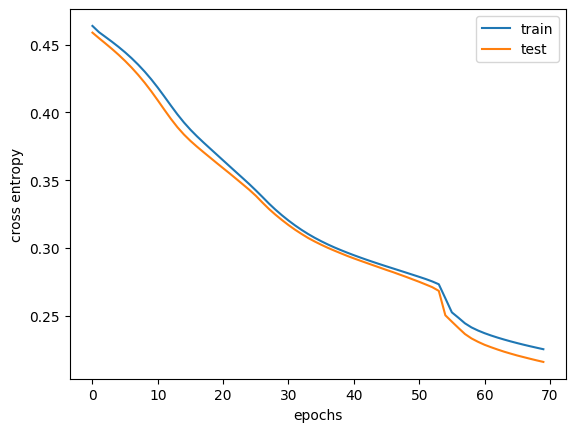

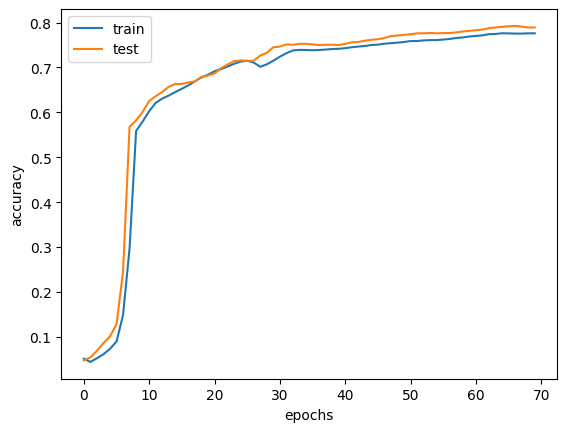

In [11]:
train(X_train1, y_train1, X_test1, y_test1, 70, 4, model1, loss_fn1, optimizer1, scheduler1)

In [13]:
def most_likely(input): 
    idx = input.argmax(axis=1)
    return idx

scoredFans2 = np.copy(scoredFans)
for idx in range(len(scoredFans2)):
    if(scoredFans2[idx] <0):
        scoredFans2[idx] = -scoredFans2[idx] + 2
    if(round(scoredFans2[idx].item(),0)==0):
        if(scoredFans2[idx]>0):
           scoredFans2[idx] = 1
        else:
            scoredFans2[idx] = -1
    else:
        scoredFans2[idx] = round(scoredFans2[idx].item(),0)
scoredFans2 = torch.tensor(scoredFans2, dtype=torch.float32)


with torch.no_grad():
    y_pred = model1(X_test1)
    y_pred2 = model1(XFans)
matches = sum(x == y for x, y in zip(most_likely(y_pred), most_likely(y_test1)))
accuracy = matches/len(y_test1)
print(f"Accuracy when testing on test bouts: {accuracy}")    
matches = sum(x == y for x, y in zip(most_likely(y_pred2), scoredFans2))
accuracy = matches/len(yFans)
print(f"Accuracy when testing on fan-scored bouts: {accuracy.data[0]}")


predictions = most_likely(model1(XFans))
expectVals = most_likely(yFans)

sames = sum(x == y for x, y in zip(expectVals, scoredFans2))
fanAccuracy = sames/len(scoredFans2)
print(f"Percent of matching judges and fan scores: {fanAccuracy.data[0]}")

print(rounds_df.columns)
for i in range(15):
    print('%s => %s (judges expected %s, fans expected %s)' % (XFans[i].tolist(), predictions[i].tolist(), expectVals[i].tolist(), scoredFans2[i].tolist()))

Accuracy when testing on test bouts: 0.792439877986908
Accuracy when testing on fan-scored bouts: 0.6782341599464417
Percent of matching judges and fan scores: 0.7456326484680176
Index(['Round score', 'Diff_Sig_Strikes_Attempted', 'Diff_Sig_Strikes_Landed',
       'Diff_KD', 'Diff_TD', 'Diff_Sub_Attempts', 'Diff_Ctrl_Time',
       'Diff_Head_Strikes'],
      dtype='object')
[26.0, 11.0, 1.0, 0.0, 0.0, 126.0, 14.0] => 1 (judges expected 1, fans expected [2.0])
[-26.0, -11.0, -1.0, 0.0, 0.0, -126.0, -14.0] => 3 (judges expected 3, fans expected [4.0])
[-9.0, 5.0, 0.0, 0.0, 0.0, 213.0, -3.0] => 1 (judges expected 1, fans expected [1.0])
[9.0, -5.0, 0.0, 0.0, 0.0, -213.0, 3.0] => 3 (judges expected 3, fans expected [3.0])
[31.0, 29.0, 0.0, 1.0, 0.0, 139.0, 28.0] => 2 (judges expected 2, fans expected [2.0])
[-31.0, -29.0, 0.0, -1.0, 0.0, -139.0, -28.0] => 3 (judges expected 4, fans expected [4.0])
[12.0, 1.0, 0.0, 1.0, 0.0, 31.0, 6.0] => 1 (judges expected 1, fans expected [1.0])
[-12.0, -

Fscore (0.77662709185346, 0.7924398625429553, 0.7833857503633372, None)


/Users/djbautista/PythonScraping/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix')

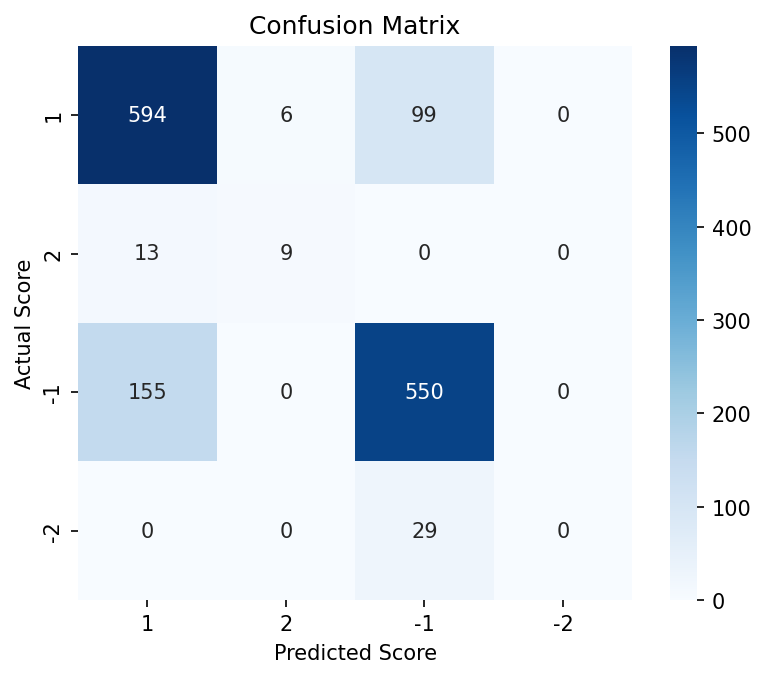

In [14]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
print('Fscore',precision_recall_fscore_support( most_likely(y_test1), most_likely(y_pred), average='weighted'))
cm = confusion_matrix(most_likely(y_test1), most_likely(y_pred))

plt.figure(dpi=150)
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['1', '2', '-1', '-2',],
           yticklabels=['1', '2', '-1', '-2',] ,fmt='.0f'
           )

plt.xlabel('Predicted Score')
plt.ylabel('Actual Score')
plt.title('Confusion Matrix')

As demonstrated, our initial estimation accuracy is generally acceptable at 80%. The accuracy is bound to drop on the fan-scored bouts since a more contested/controversial bout is more likely to be fan scored than one that isnt. Our problem is unique because the Y values of round score for our training/test sets aren't necessarily correct and contain a bit of arbitrary nature due to the subjective human element of UFC judging. Observing that about 75% of judging rounds are publicly viewed as correct, an 80% or higher accuracy would be more than acceptable. The above data shows that much of the error lies in scoring close round between 1 <-> -1, 1 <-> 2, and -1 <-> -2. Unfortunately, the accuracy of the minority classes of 10-8 rounds (~0.63) is lower than the accuracy of majority classes of 10-9 rounds (~0.81). This is the best we can do with the class weights provided. We'll create a second model that will aim to be 'objectively right' using the difference from fan scores to determine loss per batch.

In [15]:
model2 = nn.Sequential(
    nn.Linear(7, 15),
    nn.ReLU(),
    nn.Linear(15, 15),
    nn.ReLU(),
    nn.Linear(15, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    )
weights=[]
yFansVals =most_likely(yFans)
for idx in range(len(yFansVals)):
    if(yFansVals[idx]==3):
        yFansVals[idx] = -1
    elif(yFansVals[idx]==4):
        yFansVals[idx] =-2
for idx in range(len(scoredFans)):
    if((yFansVals[idx])!=(scoredFans[idx])):
        weights.append([ 1- (abs(yFansVals[idx]-scoredFans[idx])/4.1) ])
    else:
        weights.append([1])
weights = torch.tensor(weights, dtype=torch.float32)
XFans = torch.cat(( XFans, weights),dim=1)


Epoch 0: 100%|██████████| 1906/1906 [00:13<00:00, 137.06batch/s, acc=0.5, loss=0.222] 


Epoch 0 validation: Cross-entropy=0.2530347330307189, Accuracy=0.6485849022865295


Epoch 1: 100%|██████████| 1906/1906 [00:10<00:00, 178.32batch/s, acc=0.5, loss=0.219]  


Epoch 1 validation: Cross-entropy=0.2529299161919125, Accuracy=0.6474056839942932


Epoch 2: 100%|██████████| 1906/1906 [00:11<00:00, 161.33batch/s, acc=0.75, loss=0.216] 


Epoch 2 validation: Cross-entropy=0.25270998683100626, Accuracy=0.650943398475647


Epoch 3: 100%|██████████| 1906/1906 [00:08<00:00, 212.78batch/s, acc=0.75, loss=0.212] 


Epoch 3 validation: Cross-entropy=0.25230317491399196, Accuracy=0.6556603908538818


Epoch 4: 100%|██████████| 1906/1906 [00:12<00:00, 152.66batch/s, acc=0.75, loss=0.21]  


Epoch 4 validation: Cross-entropy=0.2519052103596125, Accuracy=0.6603773832321167


Epoch 5: 100%|██████████| 1906/1906 [00:08<00:00, 221.73batch/s, acc=0.75, loss=0.208] 


Epoch 5 validation: Cross-entropy=0.251640197843878, Accuracy=0.6639150977134705


Epoch 6: 100%|██████████| 1906/1906 [00:08<00:00, 217.98batch/s, acc=0.75, loss=0.207] 


Epoch 6 validation: Cross-entropy=0.25133943575879747, Accuracy=0.661556601524353


Epoch 7: 100%|██████████| 1906/1906 [00:07<00:00, 251.11batch/s, acc=0.75, loss=0.206] 


Epoch 7 validation: Cross-entropy=0.25103063826036065, Accuracy=0.6603773832321167


Epoch 8: 100%|██████████| 1906/1906 [00:07<00:00, 255.72batch/s, acc=0.75, loss=0.204] 


Epoch 8 validation: Cross-entropy=0.250680121160821, Accuracy=0.661556601524353


Epoch 9: 100%|██████████| 1906/1906 [00:11<00:00, 169.44batch/s, acc=0.75, loss=0.202] 


Epoch 9 validation: Cross-entropy=0.25038928991214504, Accuracy=0.661556601524353


Epoch 10: 100%|██████████| 1906/1906 [00:12<00:00, 151.06batch/s, acc=0.75, loss=0.201] 


Epoch 10 validation: Cross-entropy=0.2500803816131965, Accuracy=0.6650943160057068


Epoch 11: 100%|██████████| 1906/1906 [00:09<00:00, 194.53batch/s, acc=0.75, loss=0.2]   


Epoch 11 validation: Cross-entropy=0.24976859658568976, Accuracy=0.6639150977134705


Epoch 12: 100%|██████████| 1906/1906 [00:09<00:00, 192.18batch/s, acc=0.75, loss=0.198] 


Epoch 12 validation: Cross-entropy=0.249414018939824, Accuracy=0.6650943160057068


Epoch 13: 100%|██████████| 1906/1906 [00:08<00:00, 233.32batch/s, acc=0.75, loss=0.197] 


Epoch 13 validation: Cross-entropy=0.24894599461166403, Accuracy=0.6662735939025879


Epoch 14: 100%|██████████| 1906/1906 [00:08<00:00, 215.14batch/s, acc=0.75, loss=0.196] 


Epoch 14 validation: Cross-entropy=0.2485557074194402, Accuracy=0.6674528121948242


Epoch 15: 100%|██████████| 1906/1906 [00:07<00:00, 238.95batch/s, acc=0.75, loss=0.195] 


Epoch 15 validation: Cross-entropy=0.2482226453043758, Accuracy=0.6662735939025879


Epoch 16: 100%|██████████| 1906/1906 [00:07<00:00, 251.83batch/s, acc=0.75, loss=0.193] 


Epoch 16 validation: Cross-entropy=0.2479019154052394, Accuracy=0.6698113083839417


Epoch 17: 100%|██████████| 1906/1906 [00:07<00:00, 260.05batch/s, acc=0.75, loss=0.192] 


Epoch 17 validation: Cross-entropy=0.24739877263123303, Accuracy=0.6709905862808228


Epoch 18: 100%|██████████| 1906/1906 [00:07<00:00, 242.04batch/s, acc=0.75, loss=0.192] 


Epoch 18 validation: Cross-entropy=0.2470913214982364, Accuracy=0.6686320900917053


Epoch 19: 100%|██████████| 1906/1906 [00:07<00:00, 268.54batch/s, acc=0.75, loss=0.191] 


Epoch 19 validation: Cross-entropy=0.24657668366782418, Accuracy=0.6698113083839417


Epoch 20: 100%|██████████| 1906/1906 [00:07<00:00, 264.53batch/s, acc=0.75, loss=0.19]  


Epoch 20 validation: Cross-entropy=0.24613160888932487, Accuracy=0.6662735939025879


Epoch 21: 100%|██████████| 1906/1906 [00:07<00:00, 252.59batch/s, acc=0.75, loss=0.189] 


Epoch 21 validation: Cross-entropy=0.24577261054384697, Accuracy=0.6662735939025879


Epoch 22: 100%|██████████| 1906/1906 [00:09<00:00, 197.57batch/s, acc=0.75, loss=0.188] 


Epoch 22 validation: Cross-entropy=0.24524441508161776, Accuracy=0.6662735939025879


Epoch 23: 100%|██████████| 1906/1906 [00:10<00:00, 185.64batch/s, acc=0.75, loss=0.187] 


Epoch 23 validation: Cross-entropy=0.24471816400648663, Accuracy=0.6674528121948242


Epoch 24: 100%|██████████| 1906/1906 [00:07<00:00, 257.57batch/s, acc=0.75, loss=0.186] 


Epoch 24 validation: Cross-entropy=0.24398433503055877, Accuracy=0.6686320900917053


Epoch 25: 100%|██████████| 1906/1906 [00:07<00:00, 262.57batch/s, acc=0.75, loss=0.184] 


Epoch 25 validation: Cross-entropy=0.24363866297629005, Accuracy=0.6709905862808228


Epoch 26: 100%|██████████| 1906/1906 [00:07<00:00, 260.05batch/s, acc=0.75, loss=0.183] 


Epoch 26 validation: Cross-entropy=0.24300296552645548, Accuracy=0.6721698045730591


Epoch 27: 100%|██████████| 1906/1906 [00:09<00:00, 204.85batch/s, acc=0.75, loss=0.182] 


Epoch 27 validation: Cross-entropy=0.24243979879547842, Accuracy=0.6698113083839417


Epoch 28: 100%|██████████| 1906/1906 [00:08<00:00, 230.57batch/s, acc=0.75, loss=0.181] 


Epoch 28 validation: Cross-entropy=0.2421596952858561, Accuracy=0.6745283007621765


Epoch 29: 100%|██████████| 1906/1906 [00:07<00:00, 239.02batch/s, acc=0.75, loss=0.18]  


Epoch 29 validation: Cross-entropy=0.2414132248017355, Accuracy=0.6745283007621765


Epoch 30: 100%|██████████| 1906/1906 [00:09<00:00, 198.61batch/s, acc=0.75, loss=0.179] 


Epoch 30 validation: Cross-entropy=0.24084451175110705, Accuracy=0.6757075190544128


Epoch 31: 100%|██████████| 1906/1906 [00:08<00:00, 219.48batch/s, acc=0.75, loss=0.178] 


Epoch 31 validation: Cross-entropy=0.24058089745349232, Accuracy=0.6757075190544128


Epoch 32: 100%|██████████| 1906/1906 [00:09<00:00, 205.65batch/s, acc=0.75, loss=0.177] 


Epoch 32 validation: Cross-entropy=0.23994472519472337, Accuracy=0.6757075190544128


Epoch 33: 100%|██████████| 1906/1906 [00:10<00:00, 184.11batch/s, acc=0.75, loss=0.176] 


Epoch 33 validation: Cross-entropy=0.23932867309339198, Accuracy=0.6792452931404114


Epoch 34: 100%|██████████| 1906/1906 [00:10<00:00, 180.70batch/s, acc=0.75, loss=0.175] 


Epoch 34 validation: Cross-entropy=0.23873075707539082, Accuracy=0.6780660152435303


Epoch 35: 100%|██████████| 1906/1906 [00:08<00:00, 217.26batch/s, acc=0.75, loss=0.174] 


Epoch 35 validation: Cross-entropy=0.238105697433374, Accuracy=0.676886796951294


Epoch 36: 100%|██████████| 1906/1906 [00:10<00:00, 186.11batch/s, acc=0.75, loss=0.174] 


Epoch 36 validation: Cross-entropy=0.2374577419121573, Accuracy=0.6792452931404114


Epoch 37: 100%|██████████| 1906/1906 [00:10<00:00, 180.53batch/s, acc=0.75, loss=0.173] 


Epoch 37 validation: Cross-entropy=0.23677207347664264, Accuracy=0.6792452931404114


Epoch 38: 100%|██████████| 1906/1906 [00:08<00:00, 218.78batch/s, acc=0.75, loss=0.172] 


Epoch 38 validation: Cross-entropy=0.23613879422090164, Accuracy=0.6780660152435303


Epoch 39: 100%|██████████| 1906/1906 [00:08<00:00, 212.62batch/s, acc=0.75, loss=0.17]  


Epoch 39 validation: Cross-entropy=0.2353703016526022, Accuracy=0.676886796951294


Epoch 40: 100%|██████████| 1906/1906 [00:09<00:00, 200.47batch/s, acc=0.75, loss=0.17]  


Epoch 40 validation: Cross-entropy=0.23463961726918808, Accuracy=0.6792452931404114


Epoch 41: 100%|██████████| 1906/1906 [00:09<00:00, 210.12batch/s, acc=0.75, loss=0.169] 


Epoch 41 validation: Cross-entropy=0.23389095561048417, Accuracy=0.6804245114326477


Epoch 42: 100%|██████████| 1906/1906 [00:08<00:00, 224.01batch/s, acc=0.75, loss=0.168] 


Epoch 42 validation: Cross-entropy=0.23317928961091802, Accuracy=0.6804245114326477


Epoch 43: 100%|██████████| 1906/1906 [00:09<00:00, 197.98batch/s, acc=0.75, loss=0.168] 


Epoch 43 validation: Cross-entropy=0.2324471778221054, Accuracy=0.6827830076217651


Epoch 44: 100%|██████████| 1906/1906 [00:09<00:00, 190.66batch/s, acc=0.75, loss=0.166] 


Epoch 44 validation: Cross-entropy=0.23175112381110846, Accuracy=0.6839622855186462


Epoch 45: 100%|██████████| 1906/1906 [00:07<00:00, 251.95batch/s, acc=0.75, loss=0.167] 


Epoch 45 validation: Cross-entropy=0.2312185002498155, Accuracy=0.6851415038108826


Epoch 46: 100%|██████████| 1906/1906 [00:07<00:00, 242.36batch/s, acc=0.75, loss=0.165] 


Epoch 46 validation: Cross-entropy=0.23020785696482485, Accuracy=0.6851415038108826


Epoch 47: 100%|██████████| 1906/1906 [00:07<00:00, 253.64batch/s, acc=0.75, loss=0.165] 


Epoch 47 validation: Cross-entropy=0.22962974869868533, Accuracy=0.6863207817077637


Epoch 48: 100%|██████████| 1906/1906 [00:09<00:00, 203.53batch/s, acc=0.75, loss=0.164] 


Epoch 48 validation: Cross-entropy=0.228698671499116, Accuracy=0.6875


Epoch 49: 100%|██████████| 1906/1906 [00:09<00:00, 198.11batch/s, acc=0.75, loss=0.164] 


Epoch 49 validation: Cross-entropy=0.22789189060335685, Accuracy=0.6886792182922363


Epoch 50: 100%|██████████| 1906/1906 [00:13<00:00, 140.50batch/s, acc=0.75, loss=0.163] 


Epoch 50 validation: Cross-entropy=0.22707852177071183, Accuracy=0.6886792182922363


Epoch 51: 100%|██████████| 1906/1906 [00:14<00:00, 134.63batch/s, acc=0.75, loss=0.163] 


Epoch 51 validation: Cross-entropy=0.22634358673535285, Accuracy=0.6910377144813538


Epoch 52: 100%|██████████| 1906/1906 [00:08<00:00, 224.90batch/s, acc=0.75, loss=0.162] 


Epoch 52 validation: Cross-entropy=0.2253138569154847, Accuracy=0.6910377144813538


Epoch 53: 100%|██████████| 1906/1906 [00:08<00:00, 213.68batch/s, acc=0.75, loss=0.162] 


Epoch 53 validation: Cross-entropy=0.22450975381227403, Accuracy=0.6933962106704712


Epoch 54: 100%|██████████| 1906/1906 [00:08<00:00, 215.40batch/s, acc=0.75, loss=0.161] 


Epoch 54 validation: Cross-entropy=0.2233821573967651, Accuracy=0.6922169923782349


Epoch 55: 100%|██████████| 1906/1906 [00:13<00:00, 143.66batch/s, acc=0.75, loss=0.161] 


Epoch 55 validation: Cross-entropy=0.22276954844273997, Accuracy=0.6922169923782349


Epoch 56: 100%|██████████| 1906/1906 [00:09<00:00, 206.25batch/s, acc=0.75, loss=0.161] 


Epoch 56 validation: Cross-entropy=0.22196090081724315, Accuracy=0.6910377144813538


Epoch 57: 100%|██████████| 1906/1906 [00:08<00:00, 228.02batch/s, acc=0.75, loss=0.161] 


Epoch 57 validation: Cross-entropy=0.2211964082894735, Accuracy=0.6922169923782349


Epoch 58: 100%|██████████| 1906/1906 [00:08<00:00, 225.74batch/s, acc=0.75, loss=0.16]  


Epoch 58 validation: Cross-entropy=0.22025511910944906, Accuracy=0.6922169923782349


Epoch 59: 100%|██████████| 1906/1906 [00:09<00:00, 202.22batch/s, acc=0.75, loss=0.161] 


Epoch 59 validation: Cross-entropy=0.21956892731177136, Accuracy=0.6898584961891174


Epoch 60: 100%|██████████| 1906/1906 [00:09<00:00, 195.02batch/s, acc=0.75, loss=0.16]  


Epoch 60 validation: Cross-entropy=0.21867247861369407, Accuracy=0.6945754885673523


Epoch 61: 100%|██████████| 1906/1906 [00:08<00:00, 211.99batch/s, acc=0.75, loss=0.16]  


Epoch 61 validation: Cross-entropy=0.21761099563812314, Accuracy=0.6922169923782349


Epoch 62: 100%|██████████| 1906/1906 [00:07<00:00, 254.99batch/s, acc=0.75, loss=0.159] 


Epoch 62 validation: Cross-entropy=0.21679679938462565, Accuracy=0.6945754885673523


Epoch 63: 100%|██████████| 1906/1906 [00:06<00:00, 286.71batch/s, acc=0.75, loss=0.159] 


Epoch 63 validation: Cross-entropy=0.21579293842171765, Accuracy=0.698113203048706


Epoch 64: 100%|██████████| 1906/1906 [00:06<00:00, 288.82batch/s, acc=0.75, loss=0.159] 


Epoch 64 validation: Cross-entropy=0.21586538901778354, Accuracy=0.698113203048706


Epoch 65: 100%|██████████| 1906/1906 [00:06<00:00, 287.29batch/s, acc=0.75, loss=0.159] 


Epoch 65 validation: Cross-entropy=0.2143122179772176, Accuracy=0.6992924809455872


Epoch 66: 100%|██████████| 1906/1906 [00:09<00:00, 193.43batch/s, acc=0.75, loss=0.159] 


Epoch 66 validation: Cross-entropy=0.21351370556315677, Accuracy=0.7004716992378235


Epoch 67: 100%|██████████| 1906/1906 [00:06<00:00, 284.38batch/s, acc=0.75, loss=0.159] 


Epoch 67 validation: Cross-entropy=0.21282662574018119, Accuracy=0.7004716992378235


Epoch 68: 100%|██████████| 1906/1906 [00:06<00:00, 292.99batch/s, acc=0.75, loss=0.158] 


Epoch 68 validation: Cross-entropy=0.2116797657927115, Accuracy=0.7028301954269409


Epoch 69: 100%|██████████| 1906/1906 [00:06<00:00, 290.01batch/s, acc=0.75, loss=0.157] 


Epoch 69 validation: Cross-entropy=0.21064047402190647, Accuracy=0.7028301954269409


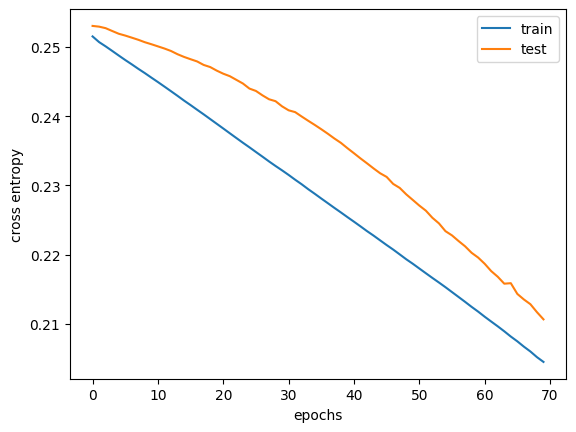

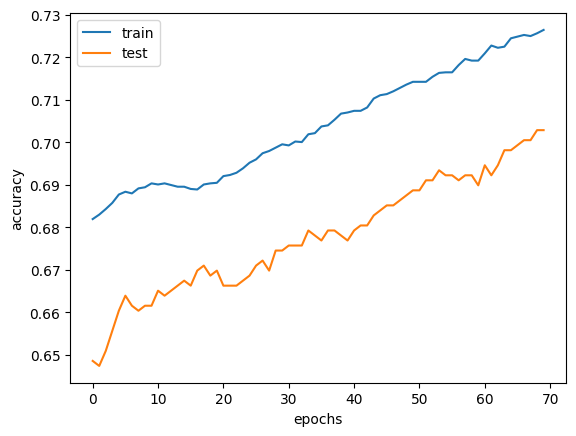

In [26]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(XFans, yFans, train_size=0.90, shuffle=True)
loss_fn2 = nn.CrossEntropyLoss(weight=torch.tensor(class_weights), reduction='none')

def loss_helper(y_pred, y_batch, X_batch):
    weight =X_batch[:, -1]
    return((loss_fn2(y_pred, y_batch)*weight).mean())
optimizer2 = optim.SGD(model2.parameters(), lr=0.0001, momentum =0.7)
scheduler2 = lr_scheduler.CyclicLR(optimizer2, base_lr=0.00001, max_lr=0.001, cycle_momentum=False)

train(X_train2, y_train2, X_test2, y_test2, 70, 4, model2, loss_helper, optimizer2, scheduler2)

The accuracy for this new model will be lower since we're not specifically trying to match the judging patterns of either the judges or fans, but using both of them to train a unique guessing pattern. Essentially, we've created an artificial archair judge based off of fan reactions to judge decisions. 

In [27]:
with torch.no_grad():
    y_pred = model2(X_test1)
    y_pred2 = model2(XFans[:, :7])
matches = sum(x == y for x, y in zip(most_likely(y_pred), most_likely(y_test1)))
accuracy = matches/len(y_test1)
print(f"Accuracy when testing on test bouts: {accuracy}")    
matches = sum(x == y for x, y in zip(most_likely(y_pred2), scoredFans2))
accuracy = matches/len(yFans)
print(f"Accuracy when testing on fan-scored bouts: {accuracy.data[0]}")  

Accuracy when testing on test bouts: 0.7670103311538696
Accuracy when testing on fan-scored bouts: 0.6723324060440063


In [29]:
torch.save(model1.state_dict(), 'static/models/model1.pth')
torch.save(model2.state_dict(), 'static/models/model2.pth')

In [1]:
inputdata=[15, 17, -2, 2, 1, 50, 11]
inputdata = torch.tensor(inputdata, dtype= torch.float32)
with torch.no_grad():
    print(model1(inputdata))

NameError: name 'torch' is not defined